In [11]:
# Derived from:
#     https://www.axonlab.org/hcph-sops/data-management/eyetrack-qc/

In [44]:
# Load the autoreload extension
%load_ext autoreload
# Set autoreload to update the modules every time before executing a new line of code
%autoreload 2

%matplotlib inline
from pathlib import Path
import json
import ppjson
from importlib import reload  # For debugging purposes

import numpy as np
import pandas as pd

import eyetrackingrun as et

from IPython.display import HTML
from matplotlib import animation
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from write_bids_yiwei import EyeTrackingRun, write_bids, write_bids_from_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
BIDS_PATH = Path("D:\\Eye_Dataset\\Sub001\\230928_anatomical_MREYE_study\\ET_EDF")
session = "004"

In [32]:
# Read in tsv.gz file
# Naming convension can be modified later
# recording_file = BIDS_PATH / "sub-001" / f"ses-{session}" / "dwi" / f"sub-001_ses-{session}_acq-highres_dir-RL_recording-eyetrack_physio.tsv.gz"
recording_file = BIDS_PATH / "JB2.tsv.gz"
print(f'recording_file: {recording_file}')
recording = pd.read_csv(
    recording_file,
#     sep=r"\s+",
    sep="\t",
    na_values="n/a",
)
print(recording.head())

metadata = json.loads((
    recording_file.parent
    / recording_file.name.replace(".tsv.gz", ".json")
).read_text())
print(f'meta_data: {metadata}')

recording_file: D:\Eye_Dataset\Sub001\230928_anatomical_MREYE_study\ET_EDF\JB2.tsv.gz
   Unnamed: 0  eye1_x_coordinate  eye1_y_coordinate  eye1_pupil_size  \
0           0                NaN                NaN              NaN   
1           1                NaN                NaN              NaN   
2           2                NaN                NaN              NaN   
3           3                NaN                NaN              NaN   
4           4                NaN                NaN              NaN   

   eye1_pupil_x_coordinate  eye1_pupil_y_coordinate  eye1_href_x_coordinate  \
0                 -32768.0                 -32768.0                 -7936.0   
1                 -32768.0                 -32768.0                 -7936.0   
2                 -32768.0                 -32768.0                 -7936.0   
3                 -32768.0                 -32768.0                 -7936.0   
4                 -32768.0                 -32768.0                 -7936.0   

   eye

# Metadata and calibration

The DWI run of our protocol is the first time the eye-tracker is employed. Therefore, we always run a calibration before it is started. As a result, we will typically see the metadata corresponding to calibration on this particular run.

Now, let's print out the contents of the BIDS' sidecar JSON corresponding to the DWI in this session.

In [33]:
# print(
#     json.dumps(metadata, sort_keys=True, indent=2, cls=ppjson.CompactJSONEncoder)
# )

# Compared to the data in the link, we don;t have the following information
# "saccade": {
#     "Description": "Continuous recording of saccade events calculated by the eyetracking device (one indicates the saccade is active)."
#   },
#   "screen_ppdeg_x_coordinate": { "Description": "Screen pixels per degree (x-coordinate).", "Units": "pixels/degree" },
#   "screen_ppdeg_y_coordinate": { "Description": "Screen pixels per degree (y-coordinate).", "Units": "pixels/degree" },
#   "timestamp": { "Description": "Eye-tracker timestamp of the sampled recorded eye.", "Units": "a.u." },
#   "x_coordinate": { "Description": "Gaze position x-coordinate of the recorded eye.", "Units": "pixel" },
#   "y_coordinate": { "Description": "Gaze position y-coordinate of the recorded eye.", "Units": "pixel" }
# }

In [34]:
print(recording)

         Unnamed: 0  eye1_x_coordinate  eye1_y_coordinate  eye1_pupil_size  \
0                 0                NaN                NaN              NaN   
1                 1                NaN                NaN              NaN   
2                 2                NaN                NaN              NaN   
3                 3                NaN                NaN              NaN   
4                 4                NaN                NaN              NaN   
...             ...                ...                ...              ...   
1106532     1106532         381.500000         296.299988           2185.0   
1106533     1106533         381.600006         296.899994           2181.0   
1106534     1106534         381.700012         296.899994           2180.0   
1106535     1106535         381.299988         297.100006           2183.0   
1106536     1106536         380.799988         298.000000           2192.0   

         eye1_pupil_x_coordinate  eye1_pupil_y_coordinate  \
0 

In [37]:
data = recording[["eye1_x_coordinate", "eye1_y_coordinate"]]

print(data)
data = data[data.eye1_x_coordinate.notna() & data.eye1_y_coordinate.notna()]
print(data)

         eye1_x_coordinate  eye1_y_coordinate
0                      NaN                NaN
1                      NaN                NaN
2                      NaN                NaN
3                      NaN                NaN
4                      NaN                NaN
...                    ...                ...
1106532         381.500000         296.299988
1106533         381.600006         296.899994
1106534         381.700012         296.899994
1106535         381.299988         297.100006
1106536         380.799988         298.000000

[1106537 rows x 2 columns]
         eye1_x_coordinate  eye1_y_coordinate
156             380.100006         524.099976
157             380.100006         524.099976
158             389.299988         549.500000
159             398.399994         575.200012
160             399.500000         567.099976
...                    ...                ...
1106532         381.500000         296.299988
1106533         381.600006         296.899994
110653

In [58]:
metadata["StartTime"] = 2000
print(metadata["StartTime"] )    
t_axis = (
    recording.timestamp.values - metadata["StartTime"]
) / metadata["SamplingFrequency"]

2000


In [65]:
print(metadata["Columns"])
recording = recording.rename(
        columns={
            f"eye1_pupil_size": f"pupil_size",
            f"eye1_fixation'": f"fixation",
            f"eye1_saccade": f"saccade",
            f"eye1_blink": f"blink",
            f"eye1_x_coordinate": f"x_coordinate", 
            f"eye1_y_coordinate": f"y_coordinate"         
        }
    )

metadata["Columns"] = recording.columns.tolist()
print(metadata["Columns"])

['Unnamed: 0', 'x_coordinate', 'y_coordinate', 'pupil_size', 'eye1_pupil_x_coordinate', 'eye1_pupil_y_coordinate', 'eye1_href_x_coordinate', 'eye1_href_y_coordinate', 'fast_raw_x_velocity', 'screen_ppdeg_x_coordinate', 'screen_ppdeg_y_coordinate', 'timestamp', 'eye1_fixation', 'saccade', 'blink']
['Unnamed: 0', 'x_coordinate', 'y_coordinate', 'pupil_size', 'eye1_pupil_x_coordinate', 'eye1_pupil_y_coordinate', 'eye1_href_x_coordinate', 'eye1_href_y_coordinate', 'fast_raw_x_velocity', 'screen_ppdeg_x_coordinate', 'screen_ppdeg_y_coordinate', 'timestamp', 'eye1_fixation', 'saccade', 'blink']


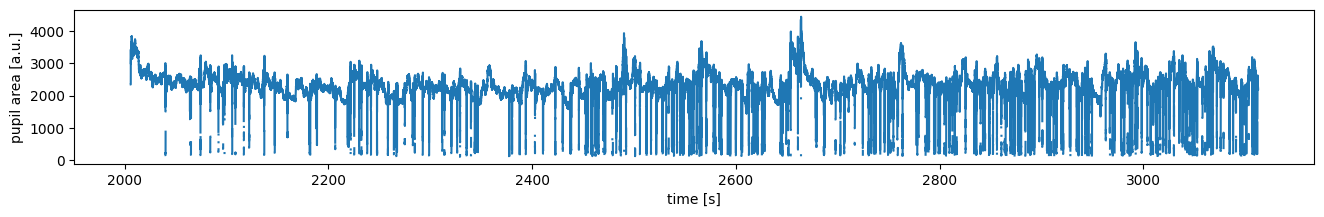

In [67]:
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["pupil_size"].values,
)

plt.xlabel("time [s]")
plt.ylabel("pupil area [a.u.]");

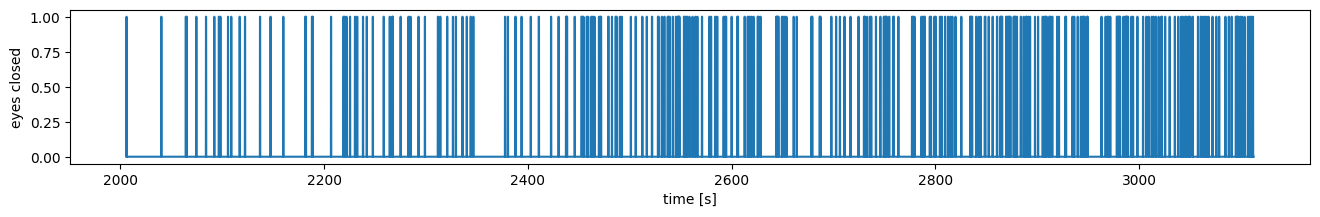

In [68]:
fig = plt.figure(figsize=(16, 2))
plt.plot(
    t_axis,
    recording["blink"].values,
)

plt.xlabel("time [s]")
plt.ylabel("eyes closed");

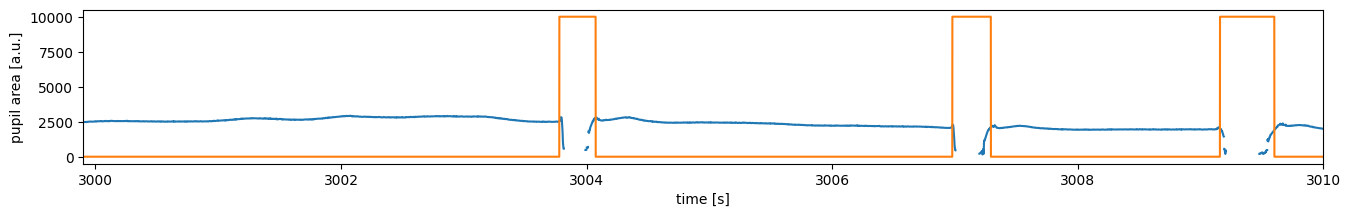

In [69]:
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis,
    recording["pupil_size"].values,
)

plt.plot(
    t_axis,
    recording["blink"].values * 10000,
)

plt.xlabel("time [s]")
plt.ylabel("pupil area [a.u.]")
plt.xlim((3000-0.1, 3010.0));

In [51]:
# pupil_area = recording["pupil_size"].values
# pupil_area[recording["blink"] > 0] = np.nan

# fig = plt.figure(figsize=(16, 2))

# plt.plot(
#     t_axis,
#     recording["pupil_size"].values,
# )

# plt.xlabel("time [s]")
# plt.ylabel("pupil area [a.u.]");

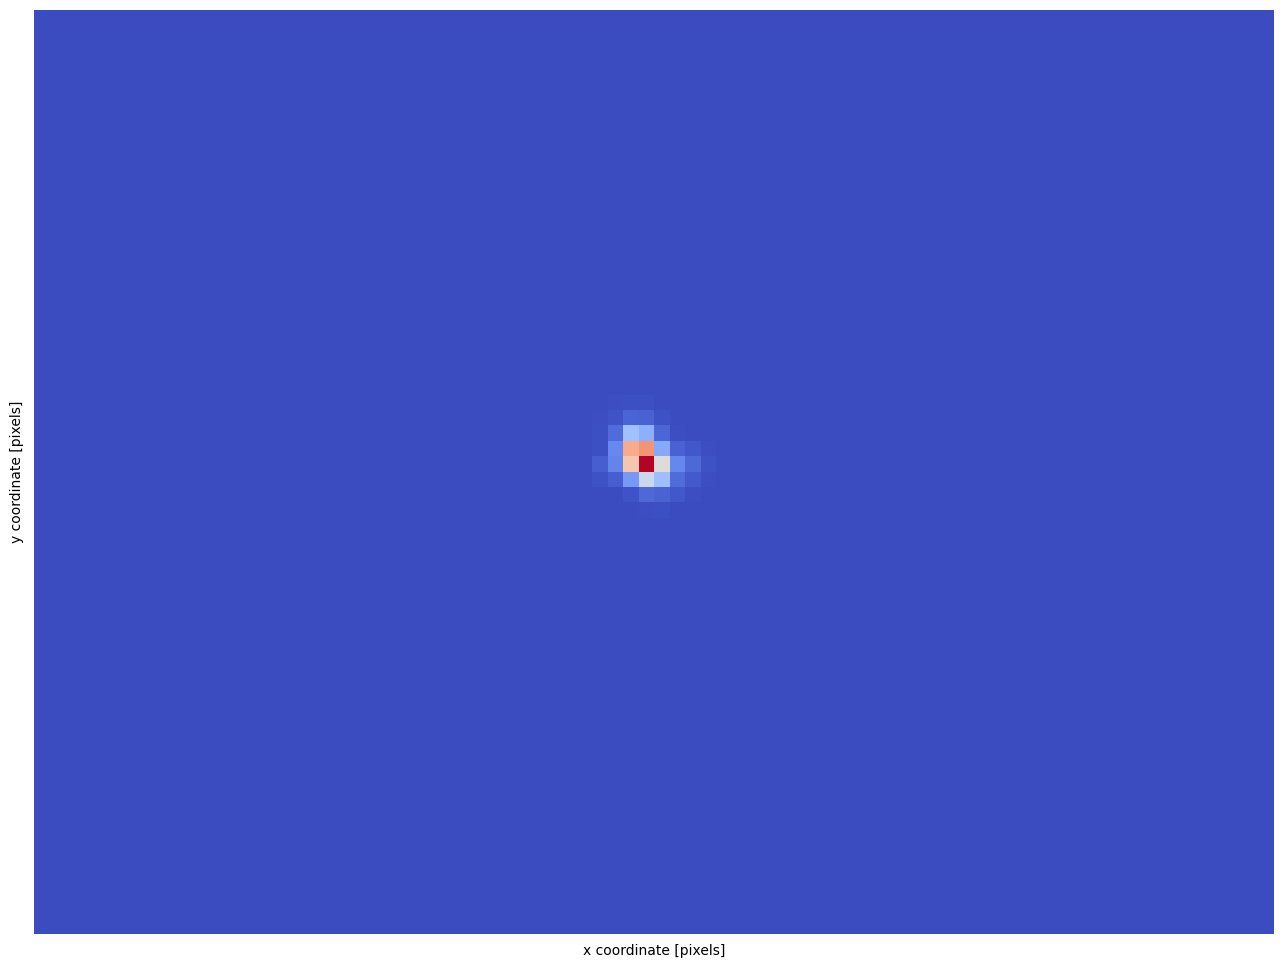

In [71]:
import plot
size = (
    metadata["ScreenAOIDefinition"][1][1],
    metadata["ScreenAOIDefinition"][1][3],
)
data = recording[["x_coordinate", "y_coordinate"]]
data = data[recording.blink < 1]
plot.plot_heatmap_coordinate(data, density=False, screen_size=size);